# Çevresel  ve Davranışsal Faktörlerin İnsan Sağlığı Üzerindeki Etkisi

#### Ahmet Deniz GÜNER ve Oktay UĞURLU

Bu projenin amacı bazı kronik hastalıkların,toplumsal davranışların ve dış etmenlerin bölgelere göre dağılımını inceleyip.Davranışsal ve dış faktörlerin hastalıklar üzerindeki etkisini toplumsal boyutda inceleyerek bir model yaratmaktır.Bu model toplumun davranışsal sorunlarını belirlemek ve bölgesel olarak hastalık dağılımını tahmin etmek üzere kullanılacaktır.

## İçerik

[Problem](#problem)   
[Verinin Anlaşılması](#data_understanding)   
[Verilerin Hazırlanması](#data_preparation)   
[Modelleme](#modeling)   
[Değerlendirme](#evaluation)   
[Referanslar](#references)   


## Problem <a class="anchor" id="problem"></a>

Son günlerde COVID-19 sayesinde gözlemlediğimiz üzere belirli alanlara yönelik sağlık yatırımlarının yeterli olmaması büyük sorunlara yol açmaktadır.Elbette bir virüs salgını öngürülemez bir etken ancak an azından öngürlebilecek hastalıklar böyle büyük sorunlara dönüşmeden gerekli önlemler alınmalıdır.Tabiki de bir hastalığın tahmin edilebilir olması için o hastalağın dış etkilerle ve davranışsal faktörlerle ilgili olması gerekir.Bu sayede önceden dış etkenler ve toplumun davranışları gözlenerek bir bölgedeki hastalıklar ileriye dönük tahmin edilerek sağlık yatırımları genişletilebilir.Aynı zamanda bu ilişkiler gözlenerek toplumsal eğitim geliştirilip , sosyal olanaklar genişletilebir.

## Verinin Anlaşılması<a class="anchor" id="data_understanding"></a>

Folium bir veri görselleştirme aracı harita üzerinde gösterim yapabilmek için projemize ekledik.

In [ ]:
pip install folium

Projemiz için gerekli olan veri bilimi ve makina öğrenmesi araçlarını ekledik.

In [78]:
import pandas as pd                                          #verileri ekleme ve gözlemleme araçları
import numpy as np 

%matplotlib inline
import matplotlib.pyplot as plt                              #veri görselleştirme araçları
import seaborn as sns; sns.set()
import folium

from sklearn.preprocessing import MinMaxScaler               #Normalizasyon aracı
from sklearn.cluster import KMeans                           #Kümelendirme aracı

from sklearn.model_selection import train_test_split   #Regression evaluation tools
from sklearn.model_selection import cross_val_score   #For evaluation of regression model


from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR 
from sklearn.ensemble import GradientBoostingRegressor   #Regression models
from sklearn.linear_model import Ridge

import urllib.request
import re                                             #regex
import warnings;
warnings.filterwarnings('ignore');
pd.options.display.max_columns = None             #verideki tüm kolonları yazdırabilmek için

Araştırmamızın ilk kısmı için CDC dan aldığımız 500 şehir üzerinde yapılmış bölgelere göre astım ve KOAH hastalığının görülme yüzdesi ve sigara kullanma yüzdelerini gösteren araştırma verileri kullandık. Aynı zamanda U.S EPA da 272 şehir üzerinde yapılmış günlük havadaki zaralı madde ölçümü verilerini de projemizde kullandık. Bütün veriler 2017 yılına aittir. 

In [79]:
diseaseAsthma = pd.read_csv("https://raw.github.com/oktayugurlu/BBM469-Sources-For-Capstone-Project/master/500_Cities__Current_asthma_among_adults_aged___18_years.csv")
diseaseCOPD = pd.read_csv("https://raw.github.com/oktayugurlu/BBM469-Sources-For-Capstone-Project/master/500_Cities__Chronic_obstructive_pulmonary_disease_among_adults_aged___18_years.csv")
cigaretePure = pd.read_csv("https://raw.github.com/oktayugurlu/BBM469-Sources-For-Capstone-Project/master/500_Cities__Current_smoking_among_adults_aged___18_years.csv") 
air_cbsa = pd.read_csv("https://raw.github.com/oktayugurlu/BBM469-Sources-For-Capstone-Project/master/daily_aqi_by_cbsa_2017.csv")

Veri hazırlama aşamasında yapmamız gereken işlemleri öngörebilmek için verinin genel drumunu inceledik boş kolonları ve sayısal veriye çevrilmesi gereken "PopulationCount" kolonunu verisini tespit ettik.

In [80]:
print("Asthma Data: " +str(diseaseAsthma.shape) )
print(diseaseAsthma.info())
print("COPD Data: " +str(diseaseCOPD.shape))
print(diseaseCOPD.info())
print("Cigarete Data: " +str(cigaretePure.shape))
print(cigaretePure.info())

Asthma Data: (29006, 24)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29006 entries, 0 to 29005
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Year                        29006 non-null  int64  
 1   StateAbbr                   29006 non-null  object 
 2   StateDesc                   29006 non-null  object 
 3   CityName                    29004 non-null  object 
 4   GeographicLevel             29006 non-null  object 
 5   DataSource                  29006 non-null  object 
 6   Category                    29006 non-null  object 
 7   UniqueID                    29006 non-null  object 
 8   Measure                     29006 non-null  object 
 9   Data_Value_Unit             29006 non-null  object 
 10  DataValueTypeID             29006 non-null  object 
 11  Data_Value_Type             29006 non-null  object 
 12  Data_Value                  28212 non-null  float64
 13  Low_Co

Astım verisinin genel görünümünü görüntüledik.

In [81]:
diseaseAsthma.head(3)

,Year,StateAbbr,StateDesc,CityName,GeographicLevel,DataSource,Category,UniqueID,Measure,Data_Value_Unit,DataValueTypeID,Data_Value_Type,Data_Value,Low_Confidence_Limit,High_Confidence_Limit,Data_Value_Footnote_Symbol,Data_Value_Footnote,PopulationCount,GeoLocation,CategoryID,MeasureId,CityFIPS,TractFIPS,Short_Question_Text
0,2017,IL,Illinois,Decatur,Census Tract,BRFSS,Health Outcomes,1718823-17115001100,Current asthma among adults aged >=18 Years,%,CrdPrv,Crude prevalence,10.0,9.5,10.5,NaN,NaN,"3,485","(39.8496654386, -88.9073271617)",HLTHOUT,CASTHMA,1718823.0,1.711500e+10,Current Asthma
1,2017,IL,Illinois,Naperville,Census Tract,BRFSS,Health Outcomes,1751622-17043846201,Current asthma among adults aged >=18 Years,%,CrdPrv,Crude prevalence,8.3,8.0,8.8,NaN,NaN,"5,832","(41.7328221894, -88.1160630821)",HLTHOUT,CASTHMA,1751622.0,1.704385e+10,Current Asthma
2,2017,IL,Illinois,Cicero,City,BRFSS,Health Outcomes,1714351,Current asthma among adults aged >=18 Years,%,AgeAdjPrv,Age-adjusted prevalence,8.4,8.2,8.6,NaN,NaN,"83,891","(41.844539143, -87.7592873023)",HLTHOUT,CASTHMA,1714351.0,NaN,Current Asthma


KOAH verisinin genel görünümünü görüntüledik.

In [82]:
diseaseCOPD.head(3)

,Year,StateAbbr,StateDesc,CityName,GeographicLevel,DataSource,Category,UniqueID,Measure,Data_Value_Unit,DataValueTypeID,Data_Value_Type,Data_Value,Low_Confidence_Limit,High_Confidence_Limit,Data_Value_Footnote_Symbol,Data_Value_Footnote,PopulationCount,GeoLocation,CategoryID,MeasureId,CityFIPS,TractFIPS,Short_Question_Text
0,2017,ID,Idaho,Boise City,Census Tract,BRFSS,Health Outcomes,1608830-16001000804,Chronic obstructive pulmonary disease among ad...,%,CrdPrv,Crude prevalence,4.6,3.9,5.4,NaN,NaN,"5,604","(43.5917744712, -116.180835276)",HLTHOUT,COPD,1608830.0,1.600100e+10,COPD
1,2017,GA,Georgia,Columbus,Census Tract,BRFSS,Health Outcomes,1319000-13215003301,Chronic obstructive pulmonary disease among ad...,%,CrdPrv,Crude prevalence,8.2,7.3,9.1,NaN,NaN,"1,317","(32.4126106139, -84.9308181793)",HLTHOUT,COPD,1319000.0,1.321500e+10,COPD
2,2017,HI,Hawaii,Honolulu,Census Tract,BRFSS,Health Outcomes,15003007000,Chronic obstructive pulmonary disease among ad...,%,CrdPrv,Crude prevalence,1.9,1.7,2.1,NaN,NaN,"4,041","(21.3445412044, -157.925563289)",HLTHOUT,COPD,15003.0,1.500301e+10,COPD


Sigara verisinin genel görünümünü görüntüledik.

In [83]:
cigaretePure.head(3)

,Year,StateAbbr,StateDesc,CityName,GeographicLevel,DataSource,Category,UniqueID,Measure,Data_Value_Unit,DataValueTypeID,Data_Value_Type,Data_Value,Low_Confidence_Limit,High_Confidence_Limit,Data_Value_Footnote_Symbol,Data_Value_Footnote,PopulationCount,GeoLocation,CategoryID,MeasureId,CityFIPS,TractFIPS,Short_Question_Text
0,2017,GA,Georgia,Savannah,Census Tract,BRFSS,Unhealthy Behaviors,1369000-13051011600,Current smoking among adults aged >=18 Years,%,CrdPrv,Crude prevalence,24.1,21.6,26.4,NaN,NaN,"2,307","(32.0899262011, -81.1328507898)",UNHBEH,CSMOKING,1369000.0,1.305101e+10,Current Smoking
1,2017,GA,Georgia,Johns Creek,Census Tract,BRFSS,Unhealthy Behaviors,1342425-13121011426,Current smoking among adults aged >=18 Years,%,CrdPrv,Crude prevalence,13.3,10.8,15.9,NaN,NaN,"1,154","(34.0365607891, -84.2419507191)",UNHBEH,CSMOKING,1342425.0,1.312101e+10,Current Smoking
2,2017,HI,Hawaii,Honolulu,Census Tract,BRFSS,Unhealthy Behaviors,15003008412,Current smoking among adults aged >=18 Years,%,CrdPrv,Crude prevalence,14.3,12.9,15.7,NaN,NaN,"6,543","(21.3403268761, -158.029720453)",UNHBEH,CSMOKING,15003.0,1.500301e+10,Current Smoking


Araştırmamız bölgesel olacağı için veri dağılım türünü inceledik ve veri hazırlama aşamasında "Age-adjusted prevalence" veri türünüde olan satırları düşürmeye karar verdik.

In [84]:
print(diseaseAsthma["Data_Value_Type"].unique())
print(diseaseCOPD["Data_Value_Type"].unique())
print(cigaretePure["Data_Value_Type"].unique())

['Crude prevalence' 'Age-adjusted prevalence']
['Crude prevalence' 'Age-adjusted prevalence']
['Crude prevalence' 'Age-adjusted prevalence']


Aşağıdaki üç hücrede sırasıyla hava kalitesi derecelendirme verisini görüntüledik,genel durumunu inceledik ve derecelendirmenin hangi maddeler üzerinden yapıldığnı görüntüledik.

In [85]:
print(air_cbsa.shape)
air_cbsa.head()

(180116, 8)


,CBSA,CBSA Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
0,"Aberdeen, SD",10100,2017-01-01,25,Good,PM2.5,46-013-0003,1
1,"Aberdeen, SD",10100,2017-01-04,48,Good,PM2.5,46-013-0003,1
2,"Aberdeen, SD",10100,2017-01-07,58,Moderate,PM2.5,46-013-0003,1
3,"Aberdeen, SD",10100,2017-01-10,40,Good,PM2.5,46-013-0003,1
4,"Aberdeen, SD",10100,2017-01-13,29,Good,PM2.5,46-013-0003,1


In [86]:
air_cbsa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180116 entries, 0 to 180115
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   CBSA                       180116 non-null  object
 1   CBSA Code                  180116 non-null  int64 
 2   Date                       180116 non-null  object
 3   AQI                        180116 non-null  int64 
 4   Category                   180116 non-null  object
 5   Defining Parameter         180116 non-null  object
 6   Defining Site              180116 non-null  object
 7   Number of Sites Reporting  180116 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 11.0+ MB


In [87]:
air_cbsa["Defining Parameter"].unique()

array(['PM2.5', 'PM10', 'Ozone', 'NO2', 'SO2', 'CO'], dtype=object)

Araştırmamızın ikici kısmı için gerekli olan verileri ekledi veri hazırlama aşamasında yapılması gereken işlemleri belirlemek için verileri inceledik.

-**alcholl**:           yüksek miktarada alkol kullanma oranı<br>                                                                -**sleepL7**:           günde 7 saatten az uyuma oranı<br>
-**mental14**:          yılda 14 günden fazla mental rahatsızlık yaşama oranı<br>
-**highBlood**:         yüksek tansiyon hastası oranı<br>
-**cancer**:            kanser hastası oranı(cilt kanseri hariç)<br>
-**cholesterol**:       kolesterol hastası oranı<br>
-**heartDisease**:      kalp krizi oranı<br>
-**obesity**:           obezite oranı<br>
-**diabete**:           şeker hastası olma oranı<br>
-**noSport**:           fiziksel aktivitede bulunmama oranı<br>
-**visitDoctor**:       düzenli sağlık kontrolüne gitme oranı<br>
-**noInsurance**:       sağlık sigortasına sahip olmama oranı<br>
-**kidneyDis**:         böbrek hastalığı oranı<br>

In [88]:
alcholl = pd.read_csv("https://raw.github.com/oktayugurlu/BBM469-Sources-For-Capstone-Project/master/500_Cities__Binge_drinking_among_adults_aged___18_years.csv")
sleepL7 = pd.read_csv("https://raw.github.com/oktayugurlu/BBM469-Sources-For-Capstone-Project/master/500_Cities__Sleeping_less_than_7_hours_among_adults_aged___18_years.csv")
mental14 = pd.read_csv("https://raw.github.com/oktayugurlu/BBM469-Sources-For-Capstone-Project/master/500_Cities__Mental_health_not_good_for___14_days_among_adults_aged___18_years.csv")
highBlood = pd.read_csv("https://raw.github.com/oktayugurlu/BBM469-Sources-For-Capstone-Project/master/500_Cities__High_blood_pressure_among_adults_aged___18_years.csv")
cancer = pd.read_csv("https://raw.github.com/oktayugurlu/BBM469-Sources-For-Capstone-Project/master/500_Cities__Cancer__excluding_skin_cancer__among_adults_aged___18_years.csv")
cholesterol = pd.read_csv("https://raw.github.com/oktayugurlu/BBM469-Sources-For-Capstone-Project/master/500_Cities__Cholesterol_screening_among_adults_aged___18_years.csv")
heartDisease = pd.read_csv("https://raw.github.com/oktayugurlu/BBM469-Sources-For-Capstone-Project/master/500_Cities__Coronary_heart_disease_among_adults_aged___18_years.csv")
obesity = pd.read_csv("https://raw.github.com/oktayugurlu/BBM469-Sources-For-Capstone-Project/master/500_Cities__Obesity_among_adults_aged___18_years.csv")
diabete = pd.read_csv("https://raw.github.com/oktayugurlu/BBM469-Sources-For-Capstone-Project/master/500_Cities__Diagnosed_diabetes_among_adults_aged___18_years.csv")
noSport = pd.read_csv("https://raw.github.com/oktayugurlu/BBM469-Sources-For-Capstone-Project/master/500_Cities__No_leisure-time_physical_activity_among_adults_aged___18_years.csv")
visitDoctor = pd.read_csv("https://raw.github.com/oktayugurlu/BBM469-Sources-For-Capstone-Project/master/500_Cities__Visits_to_doctor_for_routine_checkup_within_the_past_year_among_adults_aged___18_years.csv")
noInsurance = pd.read_csv("https://raw.github.com/oktayugurlu/BBM469-Sources-For-Capstone-Project/master/500_Cities__Current_lack_of_health_insurance_among_adults_aged_18-64_years.csv")
kidneyDis = pd.read_csv("https://raw.github.com/oktayugurlu/BBM469-Sources-For-Capstone-Project/master/500_Cities__Chronic_kidney_disease_among_adults_aged___18_years.csv")

In [89]:
dataList = [diseaseAsthma,diseaseCOPD,cigaretePure,alcholl,sleepL7,mental14,highBlood,
         cancer,cholesterol,heartDisease,obesity,diabete,noSport,visitDoctor,noInsurance,kidneyDis]
for i in dataList:
    print(i.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29006 entries, 0 to 29005
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Year                        29006 non-null  int64  
 1   StateAbbr                   29006 non-null  object 
 2   StateDesc                   29006 non-null  object 
 3   CityName                    29004 non-null  object 
 4   GeographicLevel             29006 non-null  object 
 5   DataSource                  29006 non-null  object 
 6   Category                    29006 non-null  object 
 7   UniqueID                    29006 non-null  object 
 8   Measure                     29006 non-null  object 
 9   Data_Value_Unit             29006 non-null  object 
 10  DataValueTypeID             29006 non-null  object 
 11  Data_Value_Type             29006 non-null  object 
 12  Data_Value                  28212 non-null  float64
 13  Low_Confidence_Limit        282

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29006 entries, 0 to 29005
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Year                        29006 non-null  int64  
 1   StateAbbr                   29006 non-null  object 
 2   StateDesc                   29006 non-null  object 
 3   CityName                    29004 non-null  object 
 4   GeographicLevel             29006 non-null  object 
 5   DataSource                  29006 non-null  object 
 6   Category                    29006 non-null  object 
 7   UniqueID                    29006 non-null  object 
 8   Measure                     29006 non-null  object 
 9   Data_Value_Unit             29006 non-null  object 
 10  DataValueTypeID             29006 non-null  object 
 11  Data_Value_Type             29006 non-null  object 
 12  Data_Value                  28212 non-null  float64
 13  Low_Confidence_Limit        282

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28973 entries, 0 to 28972
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Year                        28973 non-null  int64  
 1   StateAbbr                   28973 non-null  object 
 2   StateDesc                   28973 non-null  object 
 3   CityName                    28971 non-null  object 
 4   GeographicLevel             28973 non-null  object 
 5   DataSource                  28973 non-null  object 
 6   Category                    28973 non-null  object 
 7   UniqueID                    28973 non-null  object 
 8   Measure                     28973 non-null  object 
 9   Data_Value_Unit             28973 non-null  object 
 10  DataValueTypeID             28973 non-null  object 
 11  Data_Value_Type             28973 non-null  object 
 12  Data_Value                  28211 non-null  float64
 13  Low_Confidence_Limit        282

In [90]:
kidneyDis.head(3)

,Year,StateAbbr,StateDesc,CityName,GeographicLevel,DataSource,Category,UniqueID,Measure,Data_Value_Unit,DataValueTypeID,Data_Value_Type,Data_Value,Low_Confidence_Limit,High_Confidence_Limit,Data_Value_Footnote_Symbol,Data_Value_Footnote,PopulationCount,GeoLocation,CategoryID,MeasureId,CityFIPS,TractFIPS,Short_Question_Text
0,2017,GA,Georgia,Columbus,Census Tract,BRFSS,Health Outcomes,1319000-13215010502,Chronic kidney disease among adults aged >=18 ...,%,CrdPrv,Crude prevalence,3.5,3.1,3.8,NaN,NaN,"1,406","(32.5146118342, -84.8796632697)",HLTHOUT,KIDNEY,1319000.0,1.321501e+10,Chronic Kidney Disease
1,2017,HI,Hawaii,Honolulu,Census Tract,BRFSS,Health Outcomes,15003009400,Chronic kidney disease among adults aged >=18 ...,%,CrdPrv,Crude prevalence,3.7,3.5,3.9,NaN,NaN,"5,155","(21.4942478343, -158.038203503)",HLTHOUT,KIDNEY,15003.0,1.500301e+10,Chronic Kidney Disease
2,2017,HI,Hawaii,Honolulu,Census Tract,BRFSS,Health Outcomes,15003011300,Chronic kidney disease among adults aged >=18 ...,%,CrdPrv,Crude prevalence,3.6,3.5,3.8,NaN,NaN,"5,451","(21.3383298878, -157.731642152)",HLTHOUT,KIDNEY,15003.0,1.500301e+10,Chronic Kidney Disease


In [91]:
sleepL7.head(3)

,Year,StateAbbr,StateDesc,CityName,GeographicLevel,DataSource,Category,UniqueID,Measure,Data_Value_Unit,DataValueTypeID,Data_Value_Type,Data_Value,Low_Confidence_Limit,High_Confidence_Limit,Data_Value_Footnote_Symbol,Data_Value_Footnote,PopulationCount,GeoLocation,CategoryID,MeasureId,CityFIPS,TractFIPS,Short_Question_Text
0,2016,IL,Illinois,Chicago,Census Tract,BRFSS,Unhealthy Behaviors,1714000-17031840400,Sleeping less than 7 hours among adults aged >...,%,CrdPrv,Crude prevalence,36.5,35.6,37.4,NaN,NaN,"3,326","(41.8338478343, -87.6676795275)",UNHBEH,SLEEP,1714000.0,1.703184e+10,Sleep <7 hours
1,2016,IL,Illinois,Chicago,Census Tract,BRFSS,Unhealthy Behaviors,1714000-17031170800,Sleeping less than 7 hours among adults aged >...,%,CrdPrv,Crude prevalence,32.6,31.3,33.9,NaN,NaN,"3,721","(41.9415761666, -87.8123712763)",UNHBEH,SLEEP,1714000.0,1.703117e+10,Sleep <7 hours
2,2016,IL,Illinois,Chicago,Census Tract,BRFSS,Unhealthy Behaviors,1714000-17031160300,Sleeping less than 7 hours among adults aged >...,%,CrdPrv,Crude prevalence,33.6,32.4,34.9,NaN,NaN,"3,785","(41.9572682221, -87.7308957633)",UNHBEH,SLEEP,1714000.0,1.703116e+10,Sleep <7 hours


## Verilerin Hazırlanması <a class="anchor" id="data_preparation"></a>

Astım, KOAH ve sigara veri tabloları üzerinde kullanmaycağımız sütunları tablolardan düşürdük,sonrasında veri türü "Crude-prevlance" olmayan satırları da düşürdük son olarak da nüfus ile ilgili olan sütundaki veriyi de sayısal veri formatına getirdik.

In [92]:
diseaseAsthma =  diseaseAsthma[diseaseAsthma["Data_Value_Type"]=='Crude prevalence']
diseaseCOPD =  diseaseCOPD[diseaseCOPD["Data_Value_Type"]=='Crude prevalence']
cigaretePure =  cigaretePure[cigaretePure["Data_Value_Type"]=='Crude prevalence']
asthma = diseaseAsthma.drop(columns=["GeographicLevel","DataSource","Category","Measure","Data_Value_Unit","DataValueTypeID",
                       "Data_Value_Type","Data_Value_Footnote_Symbol","Data_Value_Footnote",
                    "CategoryID","MeasureId","Short_Question_Text","Year","GeoLocation","UniqueID","CityFIPS","TractFIPS"])
COPD = diseaseCOPD.drop(columns=["GeographicLevel","DataSource","Category","Measure","Data_Value_Unit","DataValueTypeID",
                       "Data_Value_Type","Data_Value_Footnote_Symbol","Data_Value_Footnote",
                    "CategoryID","MeasureId","Short_Question_Text","Year","GeoLocation","UniqueID","CityFIPS","TractFIPS"])
cigarete = cigaretePure.drop(columns=["GeographicLevel","DataSource","Category","Measure","Data_Value_Unit","DataValueTypeID",
                       "Data_Value_Type","Data_Value_Footnote_Symbol","Data_Value_Footnote",
                    "CategoryID","MeasureId","Short_Question_Text","Year","GeoLocation","UniqueID","CityFIPS","TractFIPS"])

Population = []
for i in asthma["PopulationCount"]:
    number = int(i.replace(",",""))
    Population.append(number)
asthma["Population"] = Population
asthma = asthma.drop(columns=["PopulationCount"])
Population = []
for i in COPD["PopulationCount"]:
    number = int(i.replace(",",""))
    Population.append(number)
COPD["Population"] = Population
COPD = COPD.drop(columns=["PopulationCount"])
Population = []
for i in cigarete["PopulationCount"]:
    number = int(i.replace(",",""))
    Population.append(number)
cigarete["Population"] = Population
cigarete = cigarete.drop(columns=["PopulationCount"])

asthma = asthma.dropna()
asthma["Totalpatient"] = (asthma["Data_Value"]*asthma["Population"])/100
COPD = COPD.dropna()
COPD["Totalpatient"] = (COPD["Data_Value"]*COPD["Population"])/100
cigarete = cigarete.dropna()
cigarete["Totalpatient"] = (cigarete["Data_Value"]*cigarete["Population"])/100

Elimizdeki veri 500 şehir içinde de bölgelere ayrılmış şekilde bulunmaktaydı biz bu bölgeleri 500 şehir üzerinde toplamak için aşağıdaki işlemleri yaparak verilerimiz 500 satırlı veri tabloları haline getirdik ve bu üç tabloyu birleştirilebilecek şekle getirdik.

In [93]:
StateAbbrList = []
StateDescList = []
CityNameList = []
Data_ValueList = []
PopulationList = []

for state in asthma["StateDesc"].unique():
    cities = asthma[asthma["StateDesc"] == state]
    for cityName in cities["CityName"].unique():
        city = cities[cities["CityName"] == cityName]
        CityNameList.append(cityName)
        StateAbbrList.append(str(city.iloc[0]["StateAbbr"]))
        StateDescList.append(str(city.iloc[0]["StateDesc"]))
        Data_ValueList.append(float(city["Totalpatient"].sum()/city["Population"].sum())*100)
        PopulationList.append(city["Population"].sum())

Data = {"StateAbbr":StateAbbrList,"StateDesc":StateDescList,"CityName":CityNameList,
        "AsthmaData_Value":Data_ValueList,"Population":PopulationList,}
AsthmaData = pd.DataFrame(Data,columns = ["CityName","StateAbbr","StateDesc","Population","AsthmaData_Value",])
AsthmaData.info()

StateAbbrList = []
StateDescList = []
CityNameList = []
Data_ValueList = []

for state in COPD["StateDesc"].unique():
    cities = COPD[COPD["StateDesc"] == state]
    for cityName in cities["CityName"].unique():
        city = cities[cities["CityName"] == cityName]
        CityNameList.append(cityName)
        StateAbbrList.append(city.iloc[0]["StateAbbr"])
        StateDescList.append(city.iloc[0]["StateDesc"])
        Data_ValueList.append(float(city["Totalpatient"].sum()/city["Population"].sum())*100)

Data = {"StateAbbr":StateAbbrList,"StateDesc":StateDescList,"CityName":CityNameList,"COPDData_Value":Data_ValueList,}
COPDData = pd.DataFrame(Data,columns = ["CityName","StateAbbr","StateDesc","COPDData_Value"])
COPDData.info()

StateAbbrList = []
StateDescList = []
CityNameList = []
Data_ValueList = []

for state in cigarete["StateDesc"].unique():
    cities = cigarete[cigarete["StateDesc"] == state]
    for cityName in cities["CityName"].unique():
        city = cities[cities["CityName"] == cityName]
        CityNameList.append(cityName)
        StateAbbrList.append(str(city.iloc[0]["StateAbbr"]))
        StateDescList.append(str(city.iloc[0]["StateDesc"]))
        Data_ValueList.append(float(city["Totalpatient"].sum()/city["Population"].sum())*100)

Data = {"StateAbbr":StateAbbrList,"StateDesc":StateDescList,"CityName":CityNameList,"cigareteData_Value":Data_ValueList}
cigareteData = pd.DataFrame(Data,columns = ["CityName","StateAbbr","StateDesc","cigareteData_Value"])
cigareteData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CityName          500 non-null    object 
 1   StateAbbr         500 non-null    object 
 2   StateDesc         500 non-null    object 
 3   Population        500 non-null    int64  
 4   AsthmaData_Value  500 non-null    float64
dtypes: float64(1), int64(1), object(3)
memory usage: 19.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CityName        500 non-null    object 
 1   StateAbbr       500 non-null    object 
 2   StateDesc       500 non-null    object 
 3   COPDData_Value  500 non-null    float64
dtypes: float64(1), object(3)
memory usage: 15.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data 

Elimizdeki üç veri tablosunu uygun bir şekilde birbirine ekledik ve verilerin birbiriyle ilişkisini görüntüledik.

In [94]:
asth = AsthmaData.sort_values(by=["StateDesc","CityName"])
asth = asth.set_index(pd.Index(range(0, 500)))
copd = COPDData.sort_values(by=["StateDesc","CityName"])
copd = copd.set_index(pd.Index(range(0, 500)))
copd = copd.drop(columns=["CityName","StateAbbr","StateDesc"])
smke = cigareteData.sort_values(by=["StateDesc","CityName"])
smke = smke.set_index(pd.Index(range(0, 500)))
smke = smke.drop(columns=["CityName","StateAbbr","StateDesc"])
df = asth
df = df.join(copd)
df = df.join(smke)
df.head()

,CityName,StateAbbr,StateDesc,Population,AsthmaData_Value,COPDData_Value,cigareteData_Value
0,Birmingham,AL,Alabama,424281,12.251924,9.358865,21.913410
1,Hoover,AL,Alabama,163211,9.195986,5.585067,13.398634
2,Huntsville,AL,Alabama,360110,10.897801,8.037243,18.449661
3,Mobile,AL,Alabama,390156,11.552697,8.864758,20.622448
4,Montgomery,AL,Alabama,411497,11.518448,8.643537,21.289517


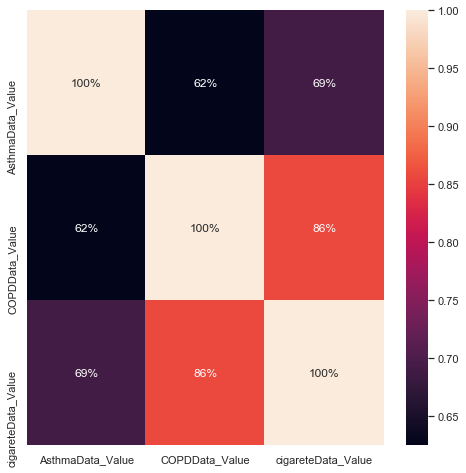

In [95]:
plt.figure(figsize=(8,8))
sns.heatmap(df[["AsthmaData_Value","COPDData_Value","cigareteData_Value"]].corr(), annot=True, fmt='.0%')

Hava kalitesi derecelendirme verisi günlük ölçüm değerlerine göre olduğu için şehirlere göre yıllık ortalamayı hesapladık.

In [96]:
CBSAList = []
AQIList = []
counter = 0
for i in air_cbsa["CBSA"].unique():
    city = air_cbsa[air_cbsa["CBSA"] == i]
    CBSAList.append(str(city.iloc[0]["CBSA"]).strip())
    AQIList.append(city["AQI"].mean())
Data = {"CBSA":CBSAList,"AQI":AQIList}
df_AQI = pd.DataFrame(Data,columns = ["CBSA","AQI"])
print(df_AQI.info())
df_AQI.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536 entries, 0 to 535
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CBSA    536 non-null    object 
 1   AQI     536 non-null    float64
dtypes: float64(1), object(1)
memory usage: 8.5+ KB
None


,CBSA,AQI
0,"Aberdeen, SD",24.663934
1,"Aberdeen, WA",24.841096
2,"Adjuntas, PR",30.595745
3,"Adrian, MI",40.409341
4,"Akron, OH",42.383562


Hava kalitesi verileriyle astım,sigara ve KOAH verilerini birleştirirken regex kullandık çünkü verileri başka kaynaklardan aldığımız için tüm şehir isimleri tam eşleşmiyordu bu sayede iki tarafta da bulunan şehirleri tespit edip bunları birleştirip 272 satırlık yeni bir tablo oluşturduk.Sonrasında bu verilerin birbiriyle ilişkilerini görüntüledik.

In [97]:
df_AQI_copy = df_AQI[:]
df_AQI_copy.loc[:,'State'] = df_AQI_copy.loc[:,'CBSA'].apply(lambda x: x.split(',')[1]) 
df_AQI_copy.loc[:,'City'] = df_AQI_copy.loc[:,'CBSA'].apply(lambda x: x.split(',')[0])
del df_AQI_copy['CBSA']

a_copy = df[:]
join_air =  pd.DataFrame(columns=["AQI","State","City"])
df_index=0
is_found = False

control = 0

a_copy = a_copy[['CityName','StateAbbr','AsthmaData_Value','COPDData_Value','cigareteData_Value']]
join_a = pd.DataFrame(columns=['CityName','StateAbbr','AsthmaData_Value','COPDData_Value','cigareteData_Value'])
join_a_index = 0
for i in range(0, a_copy['CityName'].count()):
    for j in range(0, df_AQI_copy['City'].count()):
        splitted_city = re.findall(r"[\w']+[\s\w']*", df_AQI_copy.loc[j,'City'])
        splitted_state = re.findall(r"[\w']+[\s\w']*", df_AQI_copy.loc[j,'State'])
        if(a_copy.loc[i, 'StateAbbr'] in splitted_state and a_copy.loc[i, 'CityName'] in splitted_city):
            join_air = join_air.append(df_AQI_copy.loc[j], ignore_index = True)  
            
            join_air.loc[df_index, 'City'] = a_copy.loc[i,'CityName']
            join_air.loc[df_index,'State'] = a_copy.loc[i,'StateAbbr']
            df_index+=1
            is_found = True
            control=control+1
            #print(splitted_city,splitted_state)
            
    if(control>1):
        print('-------------------Error-----------')
        
    if(is_found):
        join_a = join_a.append(a_copy.loc[i], ignore_index = True)
        join_a_index+=1
        #print(a_copy.loc[i, 'CityName'], a_copy.loc[i, 'StateAbbr'])
    control = 0    
    is_found = False

df_withAir = join_a[:]
join_air = join_air.set_index(pd.Index(range(0, 272)))
df_withAir = df_withAir.join(join_air)
pd.options.display.max_rows = 10


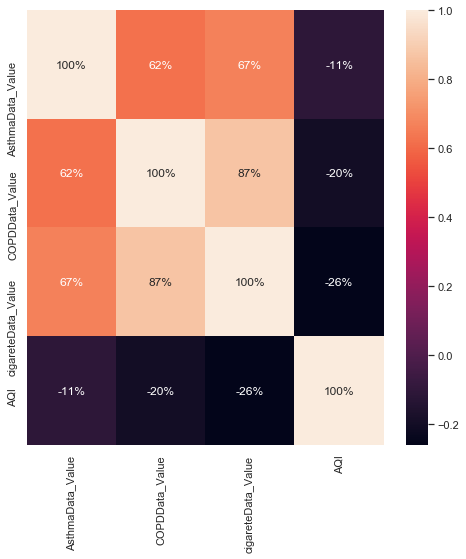

In [98]:
plt.figure(figsize=(8,8))
sns.heatmap(df_withAir.corr(), annot=True, fmt='.0%')

<img src="https://www.epa.gov/sites/production/files/styles/large/public/2019-07/aqitableforcourse.png" style="height:560px">

Isı haritasında hava kirliliği verileriyle bazı solunum hastalıkları verilerini karşılaştırdık ancak aradığımız bağlantıya ulaşamadık ve sebeplerini incelemeye karar verdik. Yukarıdaki tabloda hava derecelendirme değerine göre hava kalitesi skalası bulunmakta aşağıdaki sütun tablosunda ise Amerika'daki 532 şehrin 2017 yılı ortalama hava kalitesi değerleri görüntülenmekte.
Yukarıda ki tablo ve grafiğimizi karşılaştırdığımızda 2 şehir hariç tüm şehirlerin zaten iyi ve idare eder sınıfında hava kalitesi değerlerine sahip olduğunu gözlemlemekteyiz. Bu sebeple Amerika'daki solunum hastalıklarının sebeplerinden biri olarak hava kalitesi değerlerini bir etken olarak kullanamıyoruz.

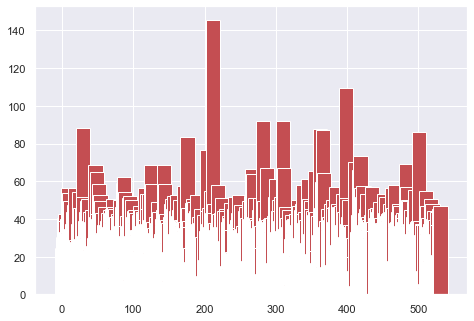

In [99]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
aqivalues = df_AQI["AQI"][0:532]
ax.bar(range(0,532),aqivalues,width=20,color = 'r')
plt.show()

<br><br><br>Projenin ikinci aşamasında kullandığımız veriler bir önceki aşamada kullandığımız sigara, KOAH ve astım verileriyle aynı formatta olduğu için bir önceki veri hazırlama aşamalarında yaptığımız süreçleri toplu olarak bu veri tabloları üzerinde de gerçekleştirerek bu verileri tek bir tabloda birleştirdik.Verilerin birbirleriyle ilişkisini görüntüledikten sonra veri hazırlama aşamasını sonlandırdık.

In [100]:
asthma = diseaseAsthma[:]
COPD = diseaseCOPD[:]
cigarete = cigaretePure[:]

In [101]:
dataList = [asthma,COPD,cigarete,alcholl,sleepL7,mental14,highBlood,
         cancer,cholesterol,heartDisease,obesity,diabete,noSport,visitDoctor,noInsurance,kidneyDis]
counter = 0
for i in dataList:
    dataList[counter] = i.drop(columns=["GeographicLevel","DataSource","Category","Measure","Data_Value_Unit",
                                         "DataValueTypeID","Data_Value_Footnote_Symbol","Data_Value_Footnote",
                    "CategoryID","MeasureId","Short_Question_Text","Year","GeoLocation","CityFIPS","TractFIPS"])
    dataList[counter] = dataList[counter].dropna()
    counter = counter + 1
counter = 0
for i in dataList:
    i = i[i["Data_Value_Type"]  == "Crude prevalence" ]
    dataList[counter] = i.sort_values(by=["StateDesc","CityName","UniqueID"])
    dataList[counter] = dataList[counter].set_index(pd.Index(range(0, len(i))))
    print(dataList[counter].info())
    counter = counter + 1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27710 entries, 0 to 27709
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   StateAbbr              27710 non-null  object 
 1   StateDesc              27710 non-null  object 
 2   CityName               27710 non-null  object 
 3   UniqueID               27710 non-null  object 
 4   Data_Value_Type        27710 non-null  object 
 5   Data_Value             27710 non-null  float64
 6   Low_Confidence_Limit   27710 non-null  float64
 7   High_Confidence_Limit  27710 non-null  float64
 8   PopulationCount        27710 non-null  object 
dtypes: float64(3), object(6)
memory usage: 1.9+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27710 entries, 0 to 27709
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   StateAbbr              27710 non-null  object 

None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27710 entries, 0 to 27709
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   StateAbbr              27710 non-null  object 
 1   StateDesc              27710 non-null  object 
 2   CityName               27710 non-null  object 
 3   UniqueID               27710 non-null  object 
 4   Data_Value_Type        27710 non-null  object 
 5   Data_Value             27710 non-null  float64
 6   Low_Confidence_Limit   27710 non-null  float64
 7   High_Confidence_Limit  27710 non-null  float64
 8   PopulationCount        27710 non-null  object 
dtypes: float64(3), object(6)
memory usage: 1.9+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27709 entries, 0 to 27708
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   StateAbbr              27709 non-null  ob

In [102]:
dataListName = ["asthma","COPD","cigarete","alcholl","sleepL7","mental14","highBlood",
         "cancer","cholesterol","heartDisease","obesity","diabete","noSport",
                "visitDoctor","noInsurance","kidneyDis"]
df_joined_all = pd.DataFrame()
counter = 0
for i in dataList:
    a = i
    if(counter == 0):
        df_joined_all["StateDesc"] = a["StateDesc"]   
        df_joined_all["StateAbbr"] = a["StateAbbr"]
        df_joined_all["CityName"] = a["CityName"]
        df_joined_all["UniqueID"] = a["UniqueID"]
        df_joined_all["PopulationCount"] = a["PopulationCount"]
    df_joined_all[dataListName[counter]] = a["Data_Value"]
    counter = counter + 1
Population = []
for i in df_joined_all["PopulationCount"]:
    number = int(i.replace(",",""))
    Population.append(number)
df_joined_all["Population"] = Population
df_joined_all = df_joined_all.drop(columns=["PopulationCount"])
df_joined_all=df_joined_all.fillna(df_joined_all.mean())
for i in dataListName:
    df_joined_all[i+"Totalpatient"] = (df_joined_all[i]*df_joined_all["Population"])/100
df_joined_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27710 entries, 0 to 27709
Data columns (total 37 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   StateDesc                 27710 non-null  object 
 1   StateAbbr                 27710 non-null  object 
 2   CityName                  27710 non-null  object 
 3   UniqueID                  27710 non-null  object 
 4   asthma                    27710 non-null  float64
 5   COPD                      27710 non-null  float64
 6   cigarete                  27710 non-null  float64
 7   alcholl                   27710 non-null  float64
 8   sleepL7                   27710 non-null  float64
 9   mental14                  27710 non-null  float64
 10  highBlood                 27710 non-null  float64
 11  cancer                    27710 non-null  float64
 12  cholesterol               27710 non-null  float64
 13  heartDisease              27710 non-null  float64
 14  obesit

In [103]:
StateAbbrList = []
StateDescList = []
CityNameList = []
PopulationList = []
asthmaList = []          
COPDList = []            
cigareteList = []          
alchollList  = []             
sleepL7List  = []             
       
mental14List = []            
highBloodList  = []           
cancerList  = []              
cholesterolList  = []         
heartDiseaseList  = []       
obesityList  = []            
diabeteList  = []             
noSportList  = []             
visitDoctorList = []
noInsuranceList = []
kidneyDisList = []
dataList = [asthmaList,COPDList,cigareteList,alchollList,sleepL7List,mental14List
            ,highBloodList,cancerList,cholesterolList,heartDiseaseList,obesityList,
            diabeteList,noSportList,visitDoctorList,noInsuranceList,kidneyDisList ]

for state in df_joined_all["StateDesc"].unique():
    cities = df_joined_all[df_joined_all["StateDesc"] == state]
    for cityName in cities["CityName"].unique():
        city = cities[cities["CityName"] == cityName]
        CityNameList.append(cityName)
        StateAbbrList.append(str(city.iloc[0]["StateAbbr"]))
        StateDescList.append(str(city.iloc[0]["StateDesc"]))
        PopulationList.append(city["Population"].sum())
        counter = 0
        for i in dataListName:
            dataList[counter].append((float(city[i+"Totalpatient"].sum())/city["Population"].sum())*100)
            counter = counter + 1

Data={"StateAbbr":StateAbbrList,"StateDesc":StateDescList,"CityName":CityNameList,"Population":PopulationList,
      "Asthma":asthmaList,"COPD":COPDList,"Cigarete":cigareteList,"Alchol":alchollList,"SleepL7":sleepL7List,
     "Mental14":mental14List,"HighBlood":highBloodList,
      "Cancer":cancerList,"Cholesterol":cholesterolList,"HeartDissease":heartDiseaseList,"Obesity":obesityList,
            "diabete":diabeteList,"NoSport":noSportList
     ,"visitDoctor":visitDoctorList,"noInsurance":noInsuranceList,"kidneyDis":kidneyDisList}
dataFrame = pd.DataFrame(Data,columns = ["CityName","StateAbbr","StateDesc","Population","Asthma","COPD","Cigarete"
                                        ,"Mental14","HighBlood","Cancer","Cholesterol","SleepL7"
                                        ,"HeartDissease","Obesity","diabete","NoSport","Alchol"
                                        ,"visitDoctor","noInsurance","kidneyDis"])
print(dataFrame.shape)
dataFrame.head()

(500, 20)


,CityName,StateAbbr,StateDesc,Population,Asthma,COPD,Cigarete,Mental14,HighBlood,Cancer,Cholesterol,SleepL7,HeartDissease,Obesity,diabete,NoSport,Alchol,visitDoctor,noInsurance,kidneyDis
0,Birmingham,AL,Alabama,424281,12.251924,9.358865,21.913410,17.054237,45.149858,5.788859,80.246343,41.637749,7.344296,41.428373,16.404284,38.021691,11.507169,75.012208,20.402446,4.036822
1,Hoover,AL,Alabama,163211,9.195986,5.585067,13.398634,11.511606,32.354112,6.681759,83.801293,32.939775,4.879805,28.794244,8.385036,24.206724,15.418704,70.969521,11.429005,2.411423
2,Huntsville,AL,Alabama,360110,10.897801,8.037243,18.449661,15.103910,37.464467,6.719593,80.173372,37.852859,6.710224,35.569746,11.837562,30.629780,13.259110,71.036000,16.242265,3.204822
3,Mobile,AL,Alabama,390156,11.552697,8.864758,20.622448,16.290866,42.319414,6.483953,80.268228,39.240658,7.625380,37.683122,14.265291,35.949839,13.539715,74.669150,18.190540,3.708303
4,Montgomery,AL,Alabama,411497,11.518448,8.643537,21.289517,16.058256,41.281709,6.058589,80.157590,38.062279,6.888911,38.530762,14.244569,34.895713,13.173401,75.019849,19.055281,3.527362


Etkenler arası ilişkileri görüntüledikten sonra bazı sütunları düşürmeye karar verdik çünkü bu sütunlar hastalıklarla daha düşük bir ilişki değeri veriyordu.Bu alanlar sağlık sigortasına sahip olmama ve düzenli doktora gitme verileriydi.

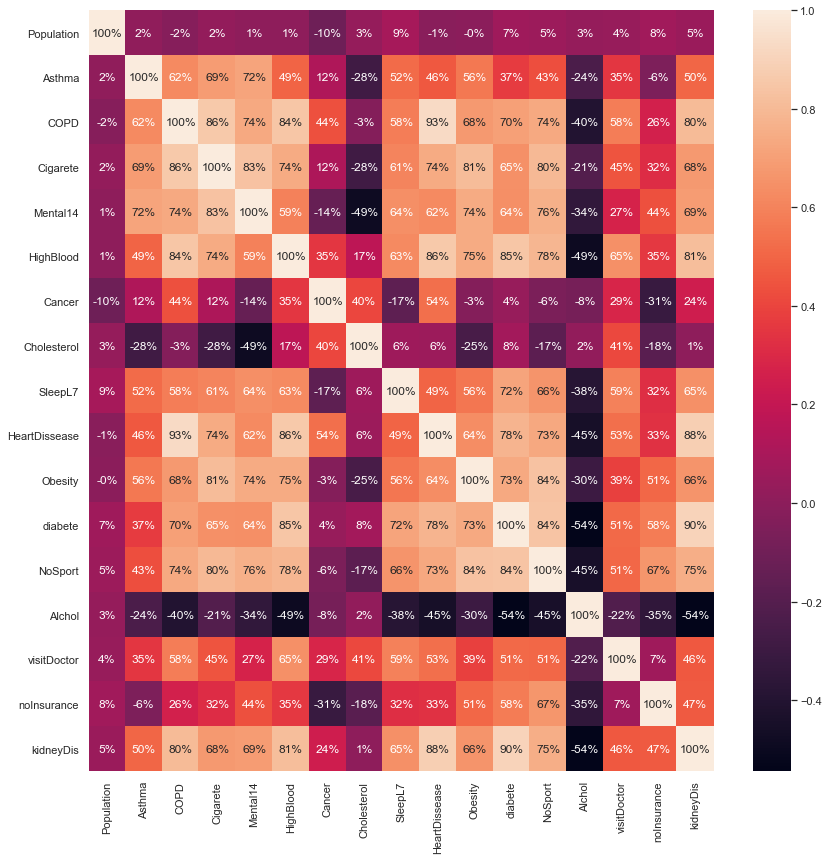

In [104]:
plt.figure(figsize=(14,14))
sns.heatmap(dataFrame.corr(), annot=True, fmt='.0%')

del dataFrame['noInsurance']
del dataFrame['visitDoctor']
del dataFrame['Cancer']
del dataFrame['Cholesterol']

Kümelendirme modelimiz için veri setimizi min-max skalasıyla normalize ettik.

In [105]:
scaler = MinMaxScaler(feature_range=(0, 1), copy=False)
min_max_scaler = MinMaxScaler() 

scaled = min_max_scaler.fit_transform(dataFrame[["Asthma","COPD","Cigarete","Mental14",
                                                 "HighBlood","SleepL7"
                                                ,"HeartDissease","Obesity","diabete","NoSport","Alchol"
                                                ,"kidneyDis"]])  
normalized_data = pd.DataFrame(scaled, columns=dataFrame[["Asthma","COPD","Cigarete","Mental14",
                                                 "HighBlood","SleepL7"
                                                ,"HeartDissease","Obesity","diabete","NoSport","Alchol"
                                                ,"kidneyDis"]].columns) 


## Modelleme <a class="anchor" id="modeling"></a>

### 1) Kümelendirme

Bu bölümde veri setimizden aldığımız hastalıklara sebep olan sağlıksız davranışlarla ilgili verilerle K-means kümelendirme metodunu uyguladık.

In [106]:
data_clustering = normalized_data[['Cigarete','Mental14','SleepL7','NoSport']]

Dirsek metoduna göre en optimal küme sayısının 2 olduğunu aşağıdaki grafikte görüyoruz.Bu metoda göre hattın nerde dirsek şeklinde kırılma yaptığına bakıyoruz. 

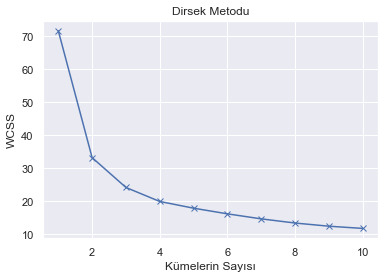

In [107]:
list_column = list(data_clustering.columns)
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(data_clustering[list_column])
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, 'bx-')
plt.title('Dirsek Metodu')
plt.xlabel('Kümelerin Sayısı')
plt.ylabel('WCSS')
plt.show() 

Kümeleme modeli uygulandıktan sonra, model kümeler için 2 farklı merkez seçer ve verileri bu merkezlere göre gruplandırır. Grupların kümelerini ve merkezlerini gözlemlemek için 'NoSport' ve 'Cigarete' sütunlarını seçtik.

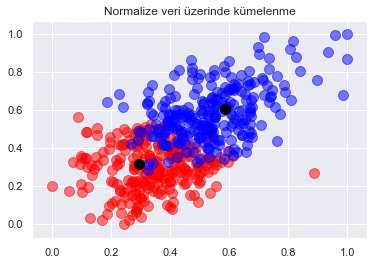

In [108]:
model = KMeans(n_clusters=2)
y = model.fit(data_clustering[list_column])
new_labels = model.predict(data_clustering) 
data_clustering['Cluster'] = new_labels 

plt.scatter(data_clustering[new_labels == 0]['SleepL7'], data_clustering[new_labels == 0]['Cigarete'], s = 100, c = 'red', label = 'malignant', alpha=0.5)
plt.scatter(data_clustering[new_labels == 1]['SleepL7'], data_clustering[new_labels == 1]['Cigarete'], s = 100, c = 'blue', label = 'belign', alpha=0.5)

plt.title("Normalize veri üzerinde kümelenme")

centers = model.cluster_centers_
plt.scatter(centers[:, 0], centers[:,1], s = 100, c = 'black', label = 'Centroids')

### 2) Regresyon

Bu bölümde, ABD kentlerinde bazı hastalıkların ortaya çıkma oranını 4 ana davranış ve diğer bazı hastalıklara göre tahmin etmeye ve bunu gerçekleştirmek için en iyi algoritmayı bulmaya çalıştık. Regresyon modelini denetimli öğrenme olarak seçtik çünkü tahminimiz oran türünden ve davranışların ve hastalıkların verilerine bağlıdır.

#### 2.1) KOAH için Tahmin:

İlk olarak koah için modelleme yapıp tahmince bulunacağız.Isı haritasından gözlemlediğimiz üzere alkol,sigara kullanımı,mental sorunların varlığını ve egzersiz eksikliğni tahmin edici etken olarak kullanacağız.

In [109]:
X = dataFrame[['Alchol','Cigarete','Mental14','NoSport']]  # tahmin parametreleri
y = dataFrame[['COPD']]                                    # tahmin edilen

Modelimizi eğitmek için veri setimizi test v eğitim verisi olarak ayırdık.

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0) 

Projemiz için en iyi algoritmayı bulmak için **SVR**, **Gradient Boosting**,**Ridge** ve **Linear Regression** modellerini analiz ettik. Modelimizi eğittik ve testlerini yaptık ve  tahminler için mean-squared hata değerini hesapladık. Eğer bu hata değeri sıfıra yakınsa bunun anlamı modelin hata payının az olduğu ve seçmek için uygun olduğudur. Mean-squared hata değerini hesaplamak için çapraz doğrulama kullandığımız için "cv" parametresini 5 olarak seçtik.

In [111]:
gradient_regression = GradientBoostingRegressor()
linear_regression = LinearRegression()
svr_regression = SVR(kernel='linear')
ridge_regression = Ridge()
    
def selection_model(X, y):
    # Perform CV to evaluate mean-squared error of Linear Regression, SVR Regression and Gradient Regression
    mean_squared_error = cross_val_score(linear_regression, X, y, scoring='neg_mean_squared_error',cv=5) 
    print('Lineer regresyon için ortalama hata karesi:', mean_squared_error.mean())

    mean_squared_error = cross_val_score(gradient_regression, X, y, scoring='neg_mean_squared_error',cv=5) 
    print("Gradient regresyon için ortalama hata karesi::", mean_squared_error.mean()) 

    mean_squared_error = cross_val_score(svr_regression, X, y, scoring='neg_mean_squared_error',cv=5) 
    print("SVR regresyon için ortalama hata karesi::", mean_squared_error.mean()) 

    mean_squared_error = cross_val_score(ridge_regression, X, y, scoring='neg_mean_squared_error',cv=5) 
    print("Ridge regresyon için ortalama hata karesi::", mean_squared_error.mean()) 

selection_model(X, y)

Lineer regresyon için ortalama hata karesi: -0.7512819023107132
Gradient regresyon için ortalama hata karesi:: -0.857280613748413
SVR regresyon için ortalama hata karesi:: -0.7772964931474505
Ridge regresyon için ortalama hata karesi:: -0.7513352578451125


Aşağıda gördüğünüz gibi modellerin doğruluğunu da gözlemleyebiliriz.

In [112]:
def score_of_models(X_train, y_train, X_test, y_test):
    gradient_regression.fit(X_train, y_train)
    linear_regression.fit(X_train,y_train) 
    svr_regression.fit(X_train, y_train) 
    ridge_regression.fit(X_train, y_train)

    score = gradient_regression.score(X_test, y_test)
    print("Gradient Regresyon Skoru: ", score)
    score = linear_regression.score(X_test, y_test)
    print("Lineer Regresyon Skoru: ", score)
    score = svr_regression.score(X_test, y_test)
    print("SVR Regresyon Skoru: ", score) 
    score = ridge_regression.score(X_test, y_test)
    print("Ridge Regresyon Skoru: ", score) 

score_of_models(X_train, y_train, X_test, y_test)

Gradient Regresyon Skoru:  0.8051182063902853
Lineer Regresyon Skoru:  0.8095908317404179
SVR Regresyon Skoru:  0.7950336668852998
Ridge Regresyon Skoru:  0.8095251202485049


Ortalama hata karesi ve başarı oranına baktığımızda en başarılı model olarak Lineer Regresyonu görüyoruz. Yüzde 80'lik başarı oranı gösteriyor.

#### 2.2) Kalp Krizi için Tahmin:

Kalp kriziyle ilgili  aşağıdaki etkenleri seçtik.
- Sigara ve alkol kullanma oranları.
- Obezite ve yüksek tansiyon hastası oranları.
- Egzersiz yapmama oranları.
- Mental sorunları olanların oranı.

In [113]:
X = dataFrame[['Alchol','Cigarete','Mental14','NoSport', 'Obesity', 'HighBlood']]  # etken sütunlar
y = dataFrame[['HeartDissease']]                                                   # tahmin edilen sütun

Daha önce de yaptığımız gibi verilerimiz eğitim ve test verisi olarak bölüyoruz ve kalp krizi oranını en iyi tahmin için algoritmaları deneyip başarı yüzdesi ve ortalama hata karesini hesaplayacağız.

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0) 

In [115]:
selection_model(X, y)

Lineer regresyon için ortalama hata karesi: -0.41867867114728086
Gradient regresyon için ortalama hata karesi:: -0.3745385729802227
SVR regresyon için ortalama hata karesi:: -0.40873121676647983
Ridge regresyon için ortalama hata karesi:: -0.4185728572674597


Önceki bölümdeki gibi başarı yüzdelerini gözlemledik.

In [116]:
score_of_models(X_train, y_train, X_test, y_test)

Gradient Regresyon Skoru:  0.8221243114875931
Lineer Regresyon Skoru:  0.8248849233710368
SVR Regresyon Skoru:  0.8168858656386291
Ridge Regresyon Skoru:  0.824870208920087


Başarı oranlarını gözlemlediğimzde **Lineer Regresyonun**  yüzde 82 ile en başarılı algoritma olduğunu görüyoruz

#### 2.3) Şeker Hastalığı için Tahmin:

Kalp kriziyle ilgili aşağıdaki etkenleri seçtik.

- Sigara ve alkol kullanma oranları.
- Obezite  hastası oranları.
- Egzersiz yapmama oranları.
- Mental sorunları olanların oranı.

In [117]:
X = dataFrame[['Alchol','Cigarete','Mental14','NoSport', 'Obesity']]  # etken sütunlar
y = dataFrame[['diabete']]                                            # tahmin edilen sütun

Daha önce de yaptığımız gibi verilerimiz eğitim ve test verisi olarak bölüyoruz ve kalp krizi oranını en iyi tahmin için algoritmaları deneyip başarı yüzdesi ve ortalama hata karesini hesaplayacağız.

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0) 

In [119]:
selection_model(X, y)

Lineer regresyon için ortalama hata karesi: -1.9945128938484153
Gradient regresyon için ortalama hata karesi:: -1.8397705656095205
SVR regresyon için ortalama hata karesi:: -2.069040319100029
Ridge regresyon için ortalama hata karesi:: -1.9941941325987798


Önceki bölümdeki gibi başarı yüzdelerini gözlemledik.

In [120]:
score_of_models(X_train, y_train, X_test, y_test)

Gradient Regresyon Skoru:  0.8329023644879486
Lineer Regresyon Skoru:  0.7813545311578307
SVR Regresyon Skoru:  0.769413891666743
Ridge Regresyon Skoru:  0.7813505148736501


**Gradient Regresyonun** şeker hastalığı için en iyi model olduğunu söyleyebiliriz çünkü başarı oranı yüzde 83 ve ortalama hata karesi 0 a yakın.

#### 2.4) Böbrek Hastalıkları için Tahmin:

Böbrek hastalıklarıyla ilgili aşağıdaki etkenleri seçtik.

- Sigara ve alkol kullanma oranları.
- Şeker  hastası oranları.
- Egzersiz yapmama oranları.
- Mental sorunları olanların oranı.

In [121]:
X = dataFrame[['Alchol','Cigarete','Mental14','NoSport', 'diabete']]  # etken sütunlar
y = dataFrame[['kidneyDis']]                                          # tahmin edilen sütun

Daha önce de yaptığımız gibi verilerimiz eğitim ve test verisi olarak bölüyoruz ve kalp krizi oranını en iyi tahmin için algoritmaları deneyip başarı yüzdesi ve ortalama hata karesini hesaplayacağız.

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0) 

In [123]:
selection_model(X, y)

Lineer regresyon için ortalama hata karesi: -0.04056406231652868
Gradient regresyon için ortalama hata karesi:: -0.05049192521839178
SVR regresyon için ortalama hata karesi:: -0.0395296138938646
Ridge regresyon için ortalama hata karesi:: -0.040568385530645325


Önceki bölümdeki gibi başarı yüzdelerini gözlemledik.

In [124]:
score_of_models(X_train, y_train, X_test, y_test)

Gradient Regresyon Skoru:  0.8611176701685298
Lineer Regresyon Skoru:  0.8788256656679895
SVR Regresyon Skoru:  0.879188398794103
Ridge Regresyon Skoru:  0.8788741319670825


**SVR Regresyon** modelinin böbrek hastalığı için en iyi model olduğunu söyleyebiliriz çünkü başarı oranı yüzde 87 ve ortalama hata karesi 0 a yakın.

## Değerlendirme <a class="anchor" id="evaluation"></a>

### 1-) Kümelendirme Modeli

Model sağlıklı ve sağlıksız olmak üzere iki farklı küme oluşturdu çünkü KOAH ,Astım ,Şeker hastalığı, böbrek rahatsızlığı ve kalp rahatsızlığı sorunlarının ortalamalarını gözlemleyebiliyorduk.

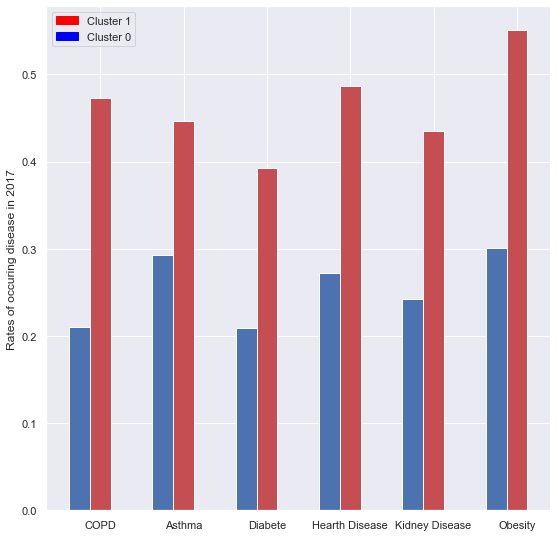

In [125]:
data_with_clusters = normalized_data[:]
data_with_clusters.loc[:,'Cluster'] = data_clustering.loc[:,'Cluster']
fig = plt.figure(figsize=(7, 7))
ax = fig.add_axes([0,0,1,1])
langs = ['COPD', 'Asthma', 'Diabete', 'Hearth Disease', 'Kidney Disease', 'Obesity']

rates_zero = [ data_with_clusters[data_with_clusters['Cluster']==0]['COPD'].mean(),
         data_with_clusters[data_with_clusters['Cluster']==0]['Asthma'].mean(),
         data_with_clusters[data_with_clusters['Cluster']==0]['diabete'].mean(),
         data_with_clusters[data_with_clusters['Cluster']==0]['HeartDissease'].mean(),
         data_with_clusters[data_with_clusters['Cluster']==0]['kidneyDis'].mean(),
         data_with_clusters[data_with_clusters['Cluster']==0]['Obesity'].mean()
            ]

rates_one = [ data_with_clusters[data_with_clusters['Cluster']==1]['COPD'].mean(),
         data_with_clusters[data_with_clusters['Cluster']==1]['Asthma'].mean(),
         data_with_clusters[data_with_clusters['Cluster']==1]['diabete'].mean(),
         data_with_clusters[data_with_clusters['Cluster']==1]['HeartDissease'].mean(),
         data_with_clusters[data_with_clusters['Cluster']==1]['kidneyDis'].mean(),
         data_with_clusters[data_with_clusters['Cluster']==1]['Obesity'].mean()
            ]
barWidth = 0.25

r1 = np.arange(6)
r2 = [x + barWidth for x in r1] 

plt.bar(r1,rates_zero,color='b', width=barWidth )
plt.bar(r2,rates_one,color='r', width=barWidth )

plt.ylabel('Rates of occuring disease in 2017')

colors = {'Cluster 1':'red', 'Cluster 0':'blue'}
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)
plt.xticks([r + barWidth for r in range(0,6)], langs)

plt.show()

Amerika haritası üzerinde eyaletlere göre kümelenmeyi görüntüledik.Bu haritadan ve yukarıdaki sütun grafiğinden batı yakasının doğu yakasına göre daha sağlıklı olduğu gözlemlenebilir.

In [126]:
data_with_clusters[['State','StateDesc','City']] = dataFrame[['StateAbbr','StateDesc','CityName']]

max = data_with_clusters.groupby('State').max()
data_with_clusters.loc[:, 'Mean of Clusters'] = max
data_with_clusters.loc[:, 'Mean of Clusters'] = data_with_clusters['Mean of Clusters'].apply(lambda x: 1 if(x>0.5) else 0)

urllib.request.urlretrieve('https://raw.github.com/oktayugurlu/BBM469-Sources-For-Capstone-Project/master/us-states.json'
                           ,filename='./us-states.json')
my_USA_map = './us-states.json'

_map_ = folium.Map(location=[40.7129, -100], zoom_start=3)

_map_.choropleth(geo_data=my_USA_map, data=data_with_clusters,
            columns=['State','Cluster'],
            key_on='feature.id', fill_color='Reds', fill_opacity=0.7, line_opacity=0.2,
           legend_name='Unhealthy-healthy Behaviour (0:Cluster 0, 1:Cluster 1)')


_map_

### 2-) Regresyon Modeli:

4 farklı hastalığı davranışlara ve diğer hastalıklara göre tahmin ettik. KOAH için lineer regresyon metodunu kullandık çünkü ortalma hata karesi ve başarı oranı en iyi olan modeldi. R^2 skoru 0.8095'di yani 1'e oldukça yakın bir değer bu da bizim bir modelde aradığımız bir özellik. Modelden de görebileceğimiz gibi, KOAH hastalığının alkol ve sigara kullanımı, zihinsel rahatsızlıkları ve egzersiz eksikliği ile güçlü bir bağlantısı var. Bu maddeler KOAH hastalığının gerçek oranını tahmin etmemize yardımcı olur ve hükümetler bu tahminleri olumsuz durumları önlemek için kullanılabilir. Regresyon eğrilerini incelediğimizde sigara kulanımının KOAH ile diğer etkenlere göre daha fazla ilişkili olduğunu gözlemliyoruz.

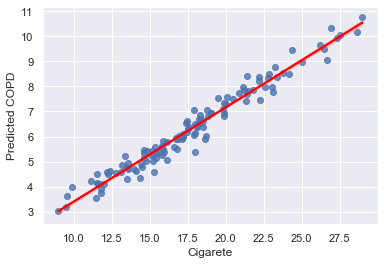

In [127]:
X = dataFrame[['Alchol','Cigarete','Mental14','NoSport']]  # predictor
y = dataFrame[['COPD']]                                    # predictand
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0) 
 
linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)
predicted = linear_regression.predict(X_test)[:,0]
df = pd.DataFrame({'Alchol': X_test['Alchol'], 'Cigarete': X_test['Cigarete'],
                   'Mental14': X_test['Mental14'], 'Mental14': X_test['Mental14'],
                   'NoSport': X_test['NoSport'], 'Predicted COPD': linear_regression.predict(X_test)[:,0]})

sns.regplot(x='Cigarete', y='Predicted COPD',data = df, line_kws={"color": "red"})

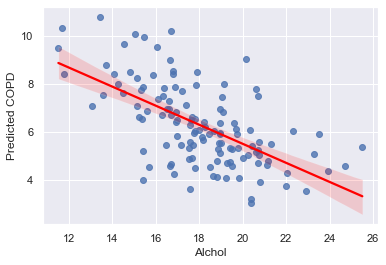

In [128]:
sns.regplot(x='Alchol', y='Predicted COPD',data = df, line_kws={"color": "red"} )

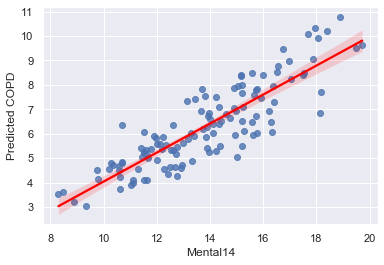

In [129]:
sns.regplot(x='Mental14', y='Predicted COPD',data = df, line_kws={"color": "red"} )

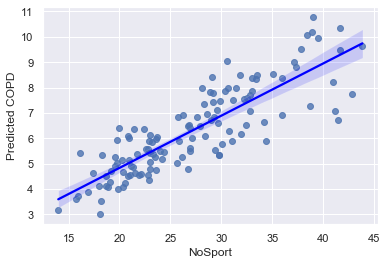

In [130]:
sns.regplot(x='NoSport', y='Predicted COPD',data = df, line_kws={"color": "blue"} ) 

Ayrıca test setinde bulunan verileri gerçek değerleriyle karşılaştırdık. Aşağıdaki tabloda da görebileceğiniz üzere değerler oldukçca yakın. 

In [131]:
df['Predicted COPD'] = predicted
df = df['Predicted COPD'] 
df = pd.DataFrame(df, index = df.index) 
df_joined = df.join(dataFrame)

df_joined

,Predicted COPD,CityName,StateAbbr,StateDesc,Population,Asthma,COPD,Cigarete,Mental14,HighBlood,SleepL7,HeartDissease,Obesity,diabete,NoSport,Alchol,kidneyDis
90,5.273659,Ontario,CA,California,327819,8.821923,4.812080,15.118612,14.218559,25.272866,39.137124,4.300631,31.157268,10.430873,26.102004,18.869158,2.817605
254,4.799622,Olathe,KS,Kansas,251744,8.701950,4.488814,14.466386,10.261003,24.136677,27.579168,3.865378,28.483364,7.192023,23.046523,21.153167,2.083072
283,10.774371,Detroit,MI,Michigan,1427494,14.309682,10.683485,28.985116,18.870271,46.826575,49.844963,8.872514,44.536030,18.282348,39.005748,13.419835,4.802950
445,4.785065,Pearland,TX,Texas,182504,7.796998,3.858710,13.481221,10.698113,28.263847,32.319527,3.796749,30.006640,8.576027,26.775707,18.796213,2.198599
461,3.989686,Sandy,UT,Utah,174866,9.205426,4.072638,9.900876,11.114193,24.170959,29.097066,4.119664,24.786549,6.867022,19.866139,15.415083,2.399808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430,5.912159,Irving,TX,Texas,432577,8.440722,4.946600,16.713576,13.383510,27.921182,33.745600,4.465715,30.269623,9.871674,31.009345,18.444676,2.533726
49,6.125490,El Cajon,CA,California,198956,9.923978,7.015732,17.976396,15.259752,30.216545,35.359669,5.700938,26.958180,10.103961,22.968705,19.673518,3.274178
134,4.085127,Tustin,CA,California,151005,8.015455,4.003775,11.965162,11.522903,24.146781,33.037241,3.797140,20.546537,8.304340,18.880834,19.813974,2.480463
365,10.194459,Cleveland,OH,Ohio,793629,11.863652,10.844878,28.601168,18.406523,39.709162,42.625730,8.620047,41.171986,17.047964,38.913269,16.705458,4.229517


Kalp hastalığı için lineer regresyon metodunu kullandık çünkü ortalma hata karesi ve başarı oranı en iyi olan modeldi. R^2 skoru 0.82'ydi. Modelden de görebileceğimiz gibi, kalp hastalığının alkol ve sigara kullanımı, zihinsel rahatsızlıkları ve egzersiz eksikliği,yüksek tansiyon ve obezite ile güçlü bir bağlantısı var.Tahmin değerleri için 6 bağımsız ve bir bağımlı değişkenin regresyon dağılımlarını grafiklerde görebilirsiniz. Grafiklere baktığımızda yüksek tansiyonla kalp krizi arasında yüksek bir ilişki gözlemliyoruz.

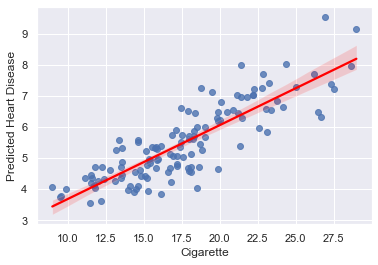

In [132]:
X = dataFrame[['Alchol','Cigarete','Mental14','NoSport','Obesity','HighBlood']] # predictor
y = dataFrame[['HeartDissease']]                                                # predictand
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0) 
 
linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)
predicted = linear_regression.predict(X_test)[:,0]
df = pd.DataFrame({'Alchol': X_test['Alchol'], 'Cigarette': X_test['Cigarete'],
                   'Mental Ilnesses': X_test['Mental14'], 'HighBlood': X_test['HighBlood'],
                   'NoSport': X_test['NoSport'], 'Predicted Heart Disease': predicted, 'Obesity': X_test['Obesity']})

sns.regplot(x='Cigarette', y='Predicted Heart Disease',data = df, line_kws={"color": "red"})

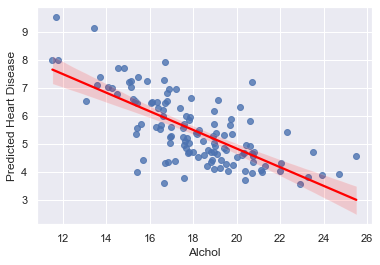

In [133]:
sns.regplot(x='Alchol', y='Predicted Heart Disease',data = df, line_kws={"color": "red"})

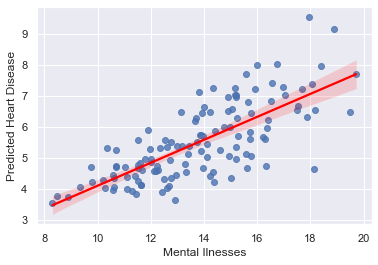

In [134]:
sns.regplot(x='Mental Ilnesses', y='Predicted Heart Disease',data = df, line_kws={"color": "red"})

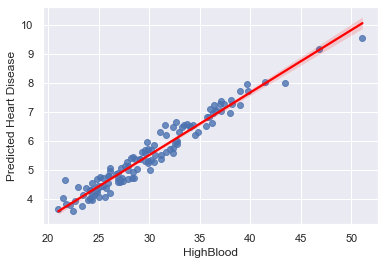

In [135]:
sns.regplot(x='HighBlood', y='Predicted Heart Disease',data = df, line_kws={"color": "red"})

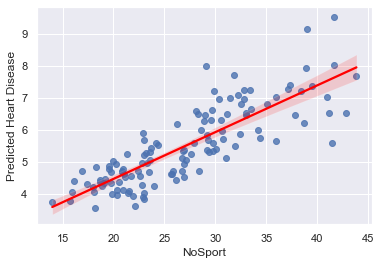

In [136]:
sns.regplot(x='NoSport', y='Predicted Heart Disease',data = df, line_kws={"color": "red"})

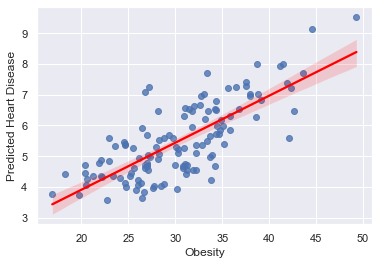

In [137]:
sns.regplot(x='Obesity', y='Predicted Heart Disease',data = df, line_kws={"color": "red"})

In [138]:
df['Predicted  Heart Disease'] = predicted
df = df['Predicted  Heart Disease'] 
df = pd.DataFrame(df, index = df.index) 
df_joined = df.join(dataFrame)

df_joined

,Predicted Heart Disease,CityName,StateAbbr,StateDesc,Population,Asthma,COPD,Cigarete,Mental14,HighBlood,SleepL7,HeartDissease,Obesity,diabete,NoSport,Alchol,kidneyDis
90,4.422125,Ontario,CA,California,327819,8.821923,4.812080,15.118612,14.218559,25.272866,39.137124,4.300631,31.157268,10.430873,26.102004,18.869158,2.817605
254,4.012733,Olathe,KS,Kansas,251744,8.701950,4.488814,14.466386,10.261003,24.136677,27.579168,3.865378,28.483364,7.192023,23.046523,21.153167,2.083072
283,9.147183,Detroit,MI,Michigan,1427494,14.309682,10.683485,28.985116,18.870271,46.826575,49.844963,8.872514,44.536030,18.282348,39.005748,13.419835,4.802950
445,4.723661,Pearland,TX,Texas,182504,7.796998,3.858710,13.481221,10.698113,28.263847,32.319527,3.796749,30.006640,8.576027,26.775707,18.796213,2.198599
461,3.999537,Sandy,UT,Utah,174866,9.205426,4.072638,9.900876,11.114193,24.170959,29.097066,4.119664,24.786549,6.867022,19.866139,15.415083,2.399808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430,5.113899,Irving,TX,Texas,432577,8.440722,4.946600,16.713576,13.383510,27.921182,33.745600,4.465715,30.269623,9.871674,31.009345,18.444676,2.533726
49,5.693600,El Cajon,CA,California,198956,9.923978,7.015732,17.976396,15.259752,30.216545,35.359669,5.700938,26.958180,10.103961,22.968705,19.673518,3.274178
134,4.255795,Tustin,CA,California,151005,8.015455,4.003775,11.965162,11.522903,24.146781,33.037241,3.797140,20.546537,8.304340,18.880834,19.813974,2.480463
365,7.943102,Cleveland,OH,Ohio,793629,11.863652,10.844878,28.601168,18.406523,39.709162,42.625730,8.620047,41.171986,17.047964,38.913269,16.705458,4.229517


Şeker hastalığını tahmin etmek için R^2 değeri 0.83 olan Gradient Regresyon modelini kullandık.Modelden de görebileceğimiz gibi, şeker hastalığının alkol ve sigara kullanımı, zihinsel rahatsızlıklar,obezite ve egzersiz eksikliği ile güçlü bir bağlantısı var.Aşağıda ilişkilerin dağılımını gösteren regresyon grafiklerini gözlemledik ve şeker hastalığının egsersiz eksikliğiyle kuvvetli bir bağlantısı olduğunu gördük.

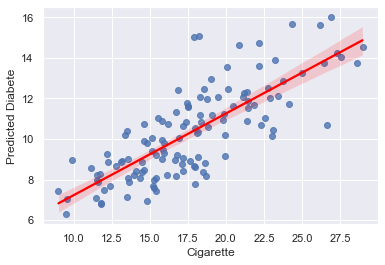

In [139]:
X = dataFrame[['Alchol','Cigarete','Mental14','NoSport','Obesity']] # predictor
y = dataFrame[['diabete']]                                                # predictand
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0) 
 
linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)
predicted = linear_regression.predict(X_test)[:,0]
df = pd.DataFrame({'Alchol': X_test['Alchol'], 'Cigarette': X_test['Cigarete'],
                   'Mental Ilnesses': X_test['Mental14'], 'NoSport': X_test['NoSport'], 
                   'Predicted Diabete': predicted, 'Obesity': X_test['Obesity']})

sns.regplot(x='Cigarette', y='Predicted Diabete',data = df, line_kws={"color": "red"})

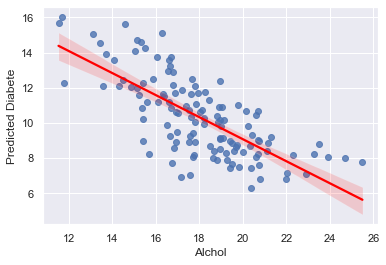

In [140]:
sns.regplot(x='Alchol', y='Predicted Diabete',data = df, line_kws={"color": "red"})

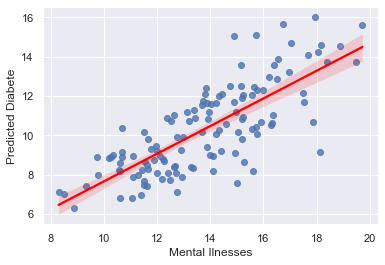

In [141]:
sns.regplot(x='Mental Ilnesses', y='Predicted Diabete',data = df, line_kws={"color": "red"})

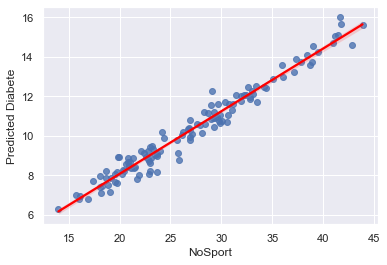

In [142]:
sns.regplot(x='NoSport', y='Predicted Diabete',data = df, line_kws={"color": "red"})

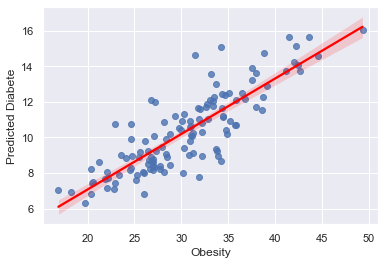

In [143]:
sns.regplot(x='Obesity', y='Predicted Diabete',data = df, line_kws={"color": "red"})

In [144]:
df['Predicted Diabete'] = predicted
df = df['Predicted Diabete'] 
df = pd.DataFrame(df, index = df.index) 
df_joined = df.join(dataFrame)

df_joined

,Predicted Diabete,CityName,StateAbbr,StateDesc,Population,Asthma,COPD,Cigarete,Mental14,HighBlood,SleepL7,HeartDissease,Obesity,diabete,NoSport,Alchol,kidneyDis
90,10.064912,Ontario,CA,California,327819,8.821923,4.812080,15.118612,14.218559,25.272866,39.137124,4.300631,31.157268,10.430873,26.102004,18.869158,2.817605
254,8.875982,Olathe,KS,Kansas,251744,8.701950,4.488814,14.466386,10.261003,24.136677,27.579168,3.865378,28.483364,7.192023,23.046523,21.153167,2.083072
283,14.553907,Detroit,MI,Michigan,1427494,14.309682,10.683485,28.985116,18.870271,46.826575,49.844963,8.872514,44.536030,18.282348,39.005748,13.419835,4.802950
445,10.391296,Pearland,TX,Texas,182504,7.796998,3.858710,13.481221,10.698113,28.263847,32.319527,3.796749,30.006640,8.576027,26.775707,18.796213,2.198599
461,8.944114,Sandy,UT,Utah,174866,9.205426,4.072638,9.900876,11.114193,24.170959,29.097066,4.119664,24.786549,6.867022,19.866139,15.415083,2.399808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430,11.309465,Irving,TX,Texas,432577,8.440722,4.946600,16.713576,13.383510,27.921182,33.745600,4.465715,30.269623,9.871674,31.009345,18.444676,2.533726
49,8.629852,El Cajon,CA,California,198956,9.923978,7.015732,17.976396,15.259752,30.216545,35.359669,5.700938,26.958180,10.103961,22.968705,19.673518,3.274178
134,7.492849,Tustin,CA,California,151005,8.015455,4.003775,11.965162,11.522903,24.146781,33.037241,3.797140,20.546537,8.304340,18.880834,19.813974,2.480463
365,13.738751,Cleveland,OH,Ohio,793629,11.863652,10.844878,28.601168,18.406523,39.709162,42.625730,8.620047,41.171986,17.047964,38.913269,16.705458,4.229517


Böbrek hastalığını tahmin etmek için R^2 değeri 0.87 olan SVR Regresyon modelini kullandık.Modelden de görebileceğimiz gibi, böbrek hastalığının alkol ve sigara kullanımı, zihinsel rahatsızlıklar,şeker hastalığı ve egzersiz eksikliği ile güçlü bir bağlantısı var.Aşağıda ilişkilerin dağılımını gösteren regresyon grafiklerini gözlemledik ve böbrek hastalığının şeker hastalığıyla kuvvetli bir bağlantısı olduğunu gördük.

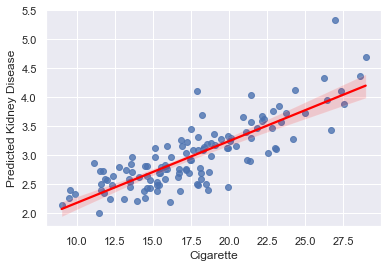

In [145]:
X = dataFrame[['Alchol','Cigarete','Mental14','NoSport','diabete']] # predictor
y = dataFrame[['kidneyDis']]                                                # predictand
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0) 
 
linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)
predicted = linear_regression.predict(X_test)[:,0]
df = pd.DataFrame({'Alchol': X_test['Alchol'], 'Cigarette': X_test['Cigarete'],
                   'Mental Ilnesses': X_test['Mental14'], 'NoSport': X_test['NoSport'], 
                   'Predicted Kidney Disease': predicted, 'diabete': X_test['diabete']})

sns.regplot(x='Cigarette', y='Predicted Kidney Disease',data = df, line_kws={"color": "red"})

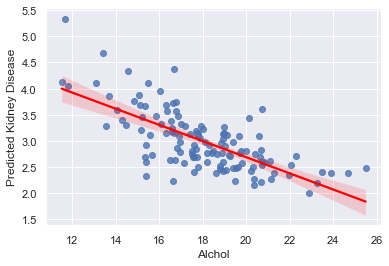

In [146]:
sns.regplot(x='Alchol', y='Predicted Kidney Disease',data = df, line_kws={"color": "red"})

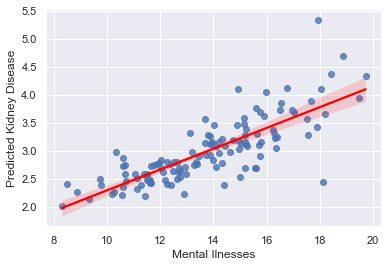

In [147]:
sns.regplot(x='Mental Ilnesses', y='Predicted Kidney Disease',data = df, line_kws={"color": "red"})

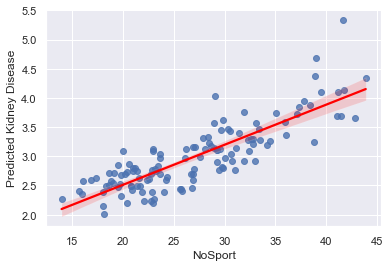

In [148]:
sns.regplot(x='NoSport', y='Predicted Kidney Disease',data = df, line_kws={"color": "red"})

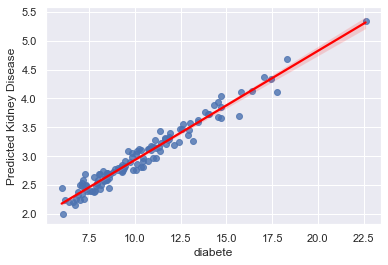

In [149]:
sns.regplot(x='diabete', y='Predicted Kidney Disease',data = df, line_kws={"color": "red"})

In [150]:
df['Predicted Kidney Disease'] = predicted
df = df['Predicted Kidney Disease'] 
df = pd.DataFrame(df, index = df.index) 
df_joined = df.join(dataFrame)

df_joined

,Predicted Kidney Disease,CityName,StateAbbr,StateDesc,Population,Asthma,COPD,Cigarete,Mental14,HighBlood,SleepL7,HeartDissease,Obesity,diabete,NoSport,Alchol,kidneyDis
90,2.966401,Ontario,CA,California,327819,8.821923,4.812080,15.118612,14.218559,25.272866,39.137124,4.300631,31.157268,10.430873,26.102004,18.869158,2.817605
254,2.265605,Olathe,KS,Kansas,251744,8.701950,4.488814,14.466386,10.261003,24.136677,27.579168,3.865378,28.483364,7.192023,23.046523,21.153167,2.083072
283,4.689296,Detroit,MI,Michigan,1427494,14.309682,10.683485,28.985116,18.870271,46.826575,49.844963,8.872514,44.536030,18.282348,39.005748,13.419835,4.802950
445,2.455294,Pearland,TX,Texas,182504,7.796998,3.858710,13.481221,10.698113,28.263847,32.319527,3.796749,30.006640,8.576027,26.775707,18.796213,2.198599
461,2.323742,Sandy,UT,Utah,174866,9.205426,4.072638,9.900876,11.114193,24.170959,29.097066,4.119664,24.786549,6.867022,19.866139,15.415083,2.399808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430,2.763836,Irving,TX,Texas,432577,8.440722,4.946600,16.713576,13.383510,27.921182,33.745600,4.465715,30.269623,9.871674,31.009345,18.444676,2.533726
49,3.086224,El Cajon,CA,California,198956,9.923978,7.015732,17.976396,15.259752,30.216545,35.359669,5.700938,26.958180,10.103961,22.968705,19.673518,3.274178
134,2.576569,Tustin,CA,California,151005,8.015455,4.003775,11.965162,11.522903,24.146781,33.037241,3.797140,20.546537,8.304340,18.880834,19.813974,2.480463
365,4.371680,Cleveland,OH,Ohio,793629,11.863652,10.844878,28.601168,18.406523,39.709162,42.625730,8.620047,41.171986,17.047964,38.913269,16.705458,4.229517


## Referanslar<a class="anchor" id="references"></a>

- Folium kütüphanesi,Amerika üzerinde kümelenmeyi göstermek için:  https://github.com/python-visualization/folium/
- Amerikada 500 şehir için hastalık ve davranış veri setleri:
https://chronicdata.cdc.gov/browse?q=500&sortBy=relevance
- Amerika hava kirliliği veri setleri: 
https://aqs.epa.gov/aqsweb/airdata/download_files.html
- Amerika haritası için json dosyasını ve csv dosyalarını kendi githubımızdan kullandık:https://github.com/oktayugurlu/BBM469-Sources-For-Capstone-Project